# DQN


### Training of DQN in Tensorflow
--------------------------

In [1]:
#
from util import *
from dlg_manager import *
from alg import *
from agent import *
from user_sim import *
from state_tracker import *
import random
from config import *
import matplotlib.pyplot as plt
import numpy as np
from nlg import *
from six.moves import cPickle as pickle
import IPython
import copy, argparse, json

%matplotlib inline
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Load Data
-------------------

#### Action Set

In [2]:
#
act_set_path = './data/dia_acts.txt'
act_set = text_to_dict(act_set_path)
sample_dict(act_set)

keys = 11
Sample of dict:
- closing: 5
- multiple_choice: 6
- greeting: 4
- confirm_answer: 3
- inform: 1


### slot set

In [3]:
#
slots_set_path = "./parser/slot_set.txt"
slot_set = text_to_dict(slots_set_path)
sample_dict(slot_set)

keys = 7
Sample of dict:
- ticket: 5
- destination1: 0
- origin1: 3
- taskcomplete: 6
- flightDate2: 1


### flight dic: info about flights

In [4]:
#
flight_kb_path = "./parser/fkb.json.p"
flight_kb = pickle.load(open(flight_kb_path, 'rb'), encoding="latin")
sample_dict(flight_kb, sample_size=1)

keys = 1000
Sample of dict:
- 424: {'destination1': 'SHA', 'travelers': '4', 'flightDate1': '2', 'flightDate2': '3', 'origin1': 'SEA'}


# Language Generator (pretrained)
-------------------

In [5]:
#
nlg_model_path ='data/trained_model/nlg/lstm_tanh_relu_[1468202263.38]_2_0.610.p'
nlg_model = Nlg()
nlg_model.load_nlg_model(nlg_model_path)
diaact_nl_pairs_path = "./parser/flight.nl.pairs.json"
nlg_model.load_predefine_act_nl_pairs(diaact_nl_pairs_path)

## Model Params

In [6]:
#
model_params = pickle.load(open(nlg_model_path, 'rb'), encoding='latin1')
params = model_params['params']
params['batch_size'] = 16
batch_size = 16
save_check_point = 20
params['trained_model_path'] = None
for k in params:
    print("{}: {}".format(k, params[k]))

dia_slot_val: 2
max_epochs: 200
grad_clip: -0.0001
hidden_size: 100
feed_recurrence: 0
slot_set: data/slot_set.txt
eva_metric: 2
data_path: .\data\movieMultiLine.Annot.Corrected.Final.v3.csv
init_rnn: 0
reg_cost: 0.001
sdgtype: rmsprop
split_method: 1
slot_rep: 1
valid_test: 0
decay_rate: 0.999
save_check_point: 20
activation_func: relu
pretrained_model_path: None
momentum: 0.1
batch_size: 16
write_model_dir: .\checkpoints\template\07102016\
cv_fold: 6
act_set: data/dia_acts.txt
trained_model_path: None
smooth_eps: 1e-08
learning_rate: 0.001
model: lstm_tanh
check_point: 20


# User Simulator
-------------------

### goal

In [7]:
#
goal_file_path = './parser/fg.json.p'
all_goal_set = pickle.load(open(goal_file_path, 'rb'), encoding="latin")
print("goals length: {}".format(len(all_goal_set)))
print("Sample the first goal: \n{}".format(all_goal_set[0]))

goals length: 128
Sample the first goal: 
{'diaact': 'request', 'request_slots': {}, 'inform_slots': {'destination1': 'MCO', 'travelers': '4', 'flightDate1': '2', 'flightDate2': '3', 'origin1': 'MUC'}}


### Split goal set

In [8]:
# split goal set
split_fold = params.get('split_fold', 5)
goal_set = {'train':[], 'valid':[], 'test':[], 'all':[]}
for u_goal_id, u_goal in enumerate(all_goal_set):
    if u_goal_id % split_fold == 1: goal_set['test'].append(u_goal)
    else: goal_set['train'].append(u_goal)
    goal_set['all'].append(u_goal)
print(len(goal_set['train']))
print(len(goal_set['valid']))
print(len(goal_set['test']))
print(len(goal_set['all']))

102
0
26
128


### user simulator param

In [9]:
#
usersim_params = {}
usersim_params['max_turn'] = 40
usersim_params['slot_err_prob'] = 0.00
# slot_err_mode: 0 for slot_val only; 1 for three errs
usersim_params['slot_err_mode'] = 0
usersim_params['intent_err_prob'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
usersim_params['run_mode'] = 0
# 0 for dia_act level; 1 for NL level
usersim_params['act_level'] = 0
# train/test/all; default is all
usersim_params['learn_phase'] = 'all'

### a flights dictionary for user simulator - slot:possible values

In [10]:
#
flight_dict_path = './parser/dicts.v3.p'
flight_dictionary = pickle.load(open(flight_dict_path, 'rb'), encoding="latin")
samples = sample_dict(flight_dictionary, sample_size=1)

keys = 20
Sample of dict:
- other: ['not available', 'movie assistant number', 'movie booking service', 'search theater', 'cannot book', 'servicing tickets', 'rotten tomatoes', 'pub serves good burgers', 'serves seafood', 'date', 'scary', 'restaurant', 'beer', 'mexican restaurant', 'best restaurant', 'japanese restaurant', "that's odd", 'crossed', 'little late', 'pub', 'number 1', 'switch cities', 'name', 'unable to book movies', 'I cannot understand your reply', 'purchase tickets', 'look up date', 'increased functionality', 'functionality', 'Master User', 'master user', 'two', 'another preference', 'no', 'check again', 'new release', 'new releases', 'place that serves seafood', 'favorite part', 'worth watching', 'subtitiles', 'subtitles', 'many many theaters', 'different selection of movies', 'search for a theater', 'latest showing', 'Italian restaurant', 'restaurant booking service', 'online ticketing', "I can't remember", "can't think of", 'search theaters', 'cheapest', 'do not know

###  Create a User

In [11]:
user = RuleSimulator(flight_dictionary, act_set, slot_set, goal_set, usersim_params)
# user = AlternateSimulator(flight_dictionary, act_set, slot_set, goal_set, usersim_params)
user.set_nlg_model(nlg_model)

# Agent
-------------------

## param

In [12]:
#
agent_params = {}
# maximum length of each dialog (default=20, 0=no maximum length)
agent_params['max_turn'] = 40
# Epsilon to determine stochasticity of epsilon-greedy agent policies
agent_params['epsilon'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
agent_params['agent_run_mode'] = 3
# 0 for dia_act level; 1 for NL level
agent_params['agent_act_level'] = 0

############### DQN #################
# the size for experience replay
agent_params['experience_replay_pool_size'] = 10000
# # the hidden size for DQN
agent_params['dqn_hidden_size'] = 60
agent_params['batch_size'] = 16
# # gamma for DQN
agent_params['gamma'] = 0.9
# # predict model for DQN
agent_params['predict_mode'] = True
agent_params['trained_model_path'] = params['pretrained_model_path']
#####################################
print("pretrained model path = {}".format(agent_params['trained_model_path']))
# 0: no warm start; 1: warm start for training
agent_params['warm_start'] = 1
# run_mode: 0 for NL; 1 for dia_act
agent_params['cmd_input_mode'] = 0

success_rate_threshold = 0.3

pretrained model path = None


### create an agent

In [13]:
# agent = RequestBasicsAgent(movie_kb, act_set, slot_set, agent_params)
# agent = AgentDQN(movie_kb, act_set, slot_set, agent_params)
# agt = 9
agt = 10
agent_params['batch_size']  = batch_size
if agt == 9:
    agent = AgentDQN(flight_kb, act_set, slot_set, agent_params)
else:
    agent = DQNAgentTF(flight_kb, act_set, slot_set, agent_params, transfer=False, path="trained_model/tf_100/model.ckpt")

agent.set_nlg_model(nlg_model)

act_cardinality  11
feasible_actions 16
80


# Dialog Manager
-------------------

In [14]:
dlg_manager = DlgManager(agent, user, act_set, slot_set, flight_kb)

## Running Episodes
-------------------

### Param

In [15]:
#
status = {'successes': 0, 'count': 0, 'cumulative_reward': 0}
# the size of validation set
simulation_epoch_size = 100
# the number of epochs for warm start 
warm_start_epochs = 20
# num_episodes = 60

In [16]:
""" Warm_Start Simulation (by Rule Policy) """
def warm_start_simulation():
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(warm_start_epochs):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("warm_start simulation episode %s: Success" % (episode))
#                 else: print ("warm_start simulation episode %s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        if len(agent.experience_replay_pool) >= agent.experience_replay_pool_size:
            break
    
    agent.warm_start = 2
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print ("Warm_Start %s epochs, success rate %s, ave reward %s, ave turns %s" % (episode+1, res['success_rate'], res['ave_reward'], res['ave_turns']))
    print ("Current experience replay buffer size %s" % (len(agent.experience_replay_pool)))

In [17]:
def simulation_epoch(simulation_epoch_size):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(simulation_epoch_size):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("simulation episode %s: Success" % (episode))
#                 else: print ("simulation episode %s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
    
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print("simulation success rate %s, ave reward %s, ave turns %s" % (res['success_rate'], res['ave_reward'], res['ave_turns']))
    return res

In [18]:
def run_episodes(count, status):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    
    if agt >= 9 and params['trained_model_path'] == None and agent.warm_start == 1:
        print ('warm_start starting ...')
        warm_start_simulation()
        print ('warm_start finished, start RL training ...')
    
    for episode in range(count):
        print ("----------------- Episode: %s ----------------- " % (episode))
        dlg_manager.init_episode()
        episode_over = False
        
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
                
            if episode_over:
                if reward > 0:
                    print ("Successful Dialog!")
                    successes += 1
#                 else: print ("Failed Dialog!")
                
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        # simulation
        if agt >= 9 and params['trained_model_path'] == None:
            agent.predict_mode = True
            simulation_res = simulation_epoch(simulation_epoch_size)
            
            performance_records['success_rate'][episode] = simulation_res['success_rate']
            performance_records['ave_turns'][episode] = simulation_res['ave_turns']
            performance_records['ave_reward'][episode] = simulation_res['ave_reward']
            
            if simulation_res['success_rate'] >= best_res['success_rate']:
                if simulation_res['success_rate'] >= success_rate_threshold: # threshold = 0.30
                    agent.experience_replay_pool = [] 
                    simulation_epoch(simulation_epoch_size)
                
#             if simulation_res['success_rate'] > best_res['success_rate']:
#                 best_model['model'] = copy.deepcopy(agent)
#                 best_res['success_rate'] = simulation_res['success_rate']
#                 best_res['ave_reward'] = simulation_res['ave_reward']
#                 best_res['ave_turns'] = simulation_res['ave_turns']
#                 best_res['epoch'] = episode
                
            loss = agent.train(batch_size, 1)
            if agt == 10: 
                agent.model.update_target_params()
            else: 
                agent.clone_dqn = copy.deepcopy(agent.dqn)
                
            agent.predict_mode = False
            
            print ("Simulation success rate %s, Ave reward %s, Ave turns %s, Best success rate %s" % (performance_records['success_rate'][episode], performance_records['ave_reward'][episode], performance_records['ave_turns'][episode], best_res['success_rate']))
#             if episode % save_check_point == 0 and params['trained_model_path'] == None: # save the model every 10 episodes
#                 save_model(params['write_model_dir'], agt, best_res['success_rate'], best_model['model'], best_res['epoch'], episode)
#                 save_performance_records(params['write_model_dir'], agt, performance_records)
        curve.append(successes/(episode+1))
        losses.append(loss)
        print("Progress: %s / %s, Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (episode+1, count, successes, episode+1, float(cumulative_reward)/(episode+1), float(cumulative_turns)/(episode+1)))
    print("Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (successes, count, float(cumulative_reward)/count, float(cumulative_turns)/count))
    status['successes'] += successes
    status['count'] += count
    
#     if agt == 9 and params['traained_model_path'] == None:
#         save_model(params['write_model_dir'], agt, float(successes)/count, best_model['model'], best_res['epoch'], count)
#         save_performance_records(params['write_model_dir'], agt, performance_records)


## Run a Warm Start

# Train & Eval
-------------------

In [19]:
performance_records = {}
performance_records['success_rate'] = {}
performance_records['ave_turns'] = {}
performance_records['ave_reward'] = {}

best_model = {}
best_res = {'success_rate': 0, 'ave_reward':float('-inf'), 'ave_turns': float('inf'), 'epoch':0}

curve = []
losses = []
agent.warm_start = 1
run_episodes(200, status)

warm_start starting ...
Warm_Start 20 epochs, success rate 0.2, ave reward 14.8, ave turns 2.8
Current experience replay buffer size 140
warm_start finished, start RL training ...
----------------- Episode: 0 ----------------- 
simulation success rate 0.0, ave reward -56.66, ave turns 35.32
Train on : 1911
- cur bellman err 11.2248, experience replay pool 1911
Simulation success rate 0.0, Ave reward -56.66, Ave turns 35.32, Best success rate 0
Progress: 1 / 200, Success rate: 0 / 1 Avg reward: -44.00 Avg turns: 10.00
----------------- Episode: 1 ----------------- 
simulation success rate 0.0, ave reward -40.0, ave turns 2.0
Train on : 2011
- cur bellman err 11.7207, experience replay pool 2011
Simulation success rate 0.0, Ave reward -40.0, Ave turns 2.0, Best success rate 0
Progress: 2 / 200, Success rate: 0 / 2 Avg reward: -42.00 Avg turns: 6.00
----------------- Episode: 2 ----------------- 
simulation success rate 0.0, ave reward -41.0, ave turns 4.0
Train on : 2211
- cur bellman er

simulation success rate 1.0, ave reward 74.04, ave turns 13.92
simulation success rate 1.0, ave reward 74.05, ave turns 13.9
Train on : 695
- cur bellman err 0.1832, experience replay pool 695
Simulation success rate 1.0, Ave reward 74.04, Ave turns 13.92, Best success rate 0
Progress: 23 / 200, Success rate: 10 / 23 Avg reward: 0.74 Avg turns: 24.87
----------------- Episode: 23 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 74.0, ave turns 14.0
simulation success rate 1.0, ave reward 74.0, ave turns 14.0
Train on : 700
- cur bellman err 0.2736, experience replay pool 700
Simulation success rate 1.0, Ave reward 74.0, Ave turns 14.0, Best success rate 0
Progress: 24 / 200, Success rate: 11 / 24 Avg reward: 3.79 Avg turns: 24.42
----------------- Episode: 24 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 74.09, ave turns 13.82
simulation success rate 1.0, ave reward 74.09, ave turns 13.82
Train on : 691
- cur bellman err 0.15

simulation success rate 1.0, ave reward 74.08, ave turns 13.84
simulation success rate 1.0, ave reward 74.11, ave turns 13.78
Train on : 689
- cur bellman err 0.1244, experience replay pool 689
Simulation success rate 1.0, Ave reward 74.08, Ave turns 13.84, Best success rate 0
Progress: 43 / 200, Success rate: 30 / 43 Avg reward: 34.86 Avg turns: 19.72
----------------- Episode: 43 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 74.19, ave turns 13.62
simulation success rate 1.0, ave reward 74.17, ave turns 13.66
Train on : 683
- cur bellman err 0.0844, experience replay pool 683
Simulation success rate 1.0, Ave reward 74.19, Ave turns 13.62, Best success rate 0
Progress: 44 / 200, Success rate: 31 / 44 Avg reward: 35.75 Avg turns: 19.59
----------------- Episode: 44 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 74.16, ave turns 13.68
simulation success rate 1.0, ave reward 74.13, ave turns 13.74
Train on : 687
- cur bellman

simulation success rate 1.0, ave reward 74.12, ave turns 13.76
simulation success rate 1.0, ave reward 74.16, ave turns 13.68
Train on : 684
- cur bellman err 0.0348, experience replay pool 684
Simulation success rate 1.0, Ave reward 74.12, Ave turns 13.76, Best success rate 0
Progress: 63 / 200, Success rate: 50 / 63 Avg reward: 47.32 Avg turns: 17.84
----------------- Episode: 63 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 74.16, ave turns 13.68
simulation success rate 1.0, ave reward 74.2, ave turns 13.6
Train on : 680
- cur bellman err 0.0537, experience replay pool 680
Simulation success rate 1.0, Ave reward 74.16, Ave turns 13.68, Best success rate 0
Progress: 64 / 200, Success rate: 51 / 64 Avg reward: 47.73 Avg turns: 17.78
----------------- Episode: 64 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 74.16, ave turns 13.68
simulation success rate 1.0, ave reward 74.08, ave turns 13.84
Train on : 692
- cur bellman e

simulation success rate 1.0, ave reward 74.11, ave turns 13.78
simulation success rate 1.0, ave reward 74.16, ave turns 13.68
Train on : 684
- cur bellman err 0.0424, experience replay pool 684
Simulation success rate 1.0, Ave reward 74.11, Ave turns 13.78, Best success rate 0
Progress: 83 / 200, Success rate: 70 / 83 Avg reward: 53.80 Avg turns: 16.82
----------------- Episode: 83 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 74.15, ave turns 13.7
simulation success rate 1.0, ave reward 74.14, ave turns 13.72
Train on : 686
- cur bellman err 0.0366, experience replay pool 686
Simulation success rate 1.0, Ave reward 74.15, Ave turns 13.7, Best success rate 0
Progress: 84 / 200, Success rate: 71 / 84 Avg reward: 54.05 Avg turns: 16.76
----------------- Episode: 84 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 74.09, ave turns 13.82
simulation success rate 1.0, ave reward 74.17, ave turns 13.66
Train on : 683
- cur bellman e

simulation success rate 1.0, ave reward 74.1, ave turns 13.8
simulation success rate 1.0, ave reward 74.15, ave turns 13.7
Train on : 685
- cur bellman err 0.0499, experience replay pool 685
Simulation success rate 1.0, Ave reward 74.1, Ave turns 13.8, Best success rate 0
Progress: 103 / 200, Success rate: 90 / 103 Avg reward: 57.76 Avg turns: 16.19
----------------- Episode: 103 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 74.17, ave turns 13.66
simulation success rate 1.0, ave reward 74.14, ave turns 13.72
Train on : 686
- cur bellman err 0.0374, experience replay pool 686
Simulation success rate 1.0, Ave reward 74.17, Ave turns 13.66, Best success rate 0
Progress: 104 / 200, Success rate: 91 / 104 Avg reward: 57.91 Avg turns: 16.17
----------------- Episode: 104 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 74.14, ave turns 13.72
simulation success rate 1.0, ave reward 74.14, ave turns 13.72
Train on : 686
- cur bellma

simulation success rate 1.0, ave reward 74.19, ave turns 13.62
simulation success rate 1.0, ave reward 74.18, ave turns 13.64
Train on : 682
- cur bellman err 0.0360, experience replay pool 682
Simulation success rate 1.0, Ave reward 74.19, Ave turns 13.62, Best success rate 0
Progress: 123 / 200, Success rate: 110 / 123 Avg reward: 60.41 Avg turns: 15.82
----------------- Episode: 123 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 74.15, ave turns 13.7
simulation success rate 1.0, ave reward 74.13, ave turns 13.74
Train on : 687
- cur bellman err 0.0314, experience replay pool 687
Simulation success rate 1.0, Ave reward 74.15, Ave turns 13.7, Best success rate 0
Progress: 124 / 200, Success rate: 111 / 124 Avg reward: 60.52 Avg turns: 15.81
----------------- Episode: 124 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 74.14, ave turns 13.72
simulation success rate 1.0, ave reward 74.12, ave turns 13.76
Train on : 688
- cur b

simulation success rate 1.0, ave reward 74.09, ave turns 13.82
simulation success rate 1.0, ave reward 74.11, ave turns 13.78
Train on : 689
- cur bellman err 0.0379, experience replay pool 689
Simulation success rate 1.0, Ave reward 74.09, Ave turns 13.82, Best success rate 0
Progress: 143 / 200, Success rate: 130 / 143 Avg reward: 62.33 Avg turns: 15.52
----------------- Episode: 143 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 74.13, ave turns 13.74
simulation success rate 1.0, ave reward 74.13, ave turns 13.74
Train on : 687
- cur bellman err 0.0239, experience replay pool 687
Simulation success rate 1.0, Ave reward 74.13, Ave turns 13.74, Best success rate 0
Progress: 144 / 200, Success rate: 131 / 144 Avg reward: 62.42 Avg turns: 15.50
----------------- Episode: 144 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 74.1, ave turns 13.8
simulation success rate 1.0, ave reward 74.13, ave turns 13.74
Train on : 687
- cur b

simulation success rate 1.0, ave reward 74.19, ave turns 13.62
simulation success rate 1.0, ave reward 74.07, ave turns 13.86
Train on : 693
- cur bellman err 0.0232, experience replay pool 693
Simulation success rate 1.0, Ave reward 74.19, Ave turns 13.62, Best success rate 0
Progress: 163 / 200, Success rate: 150 / 163 Avg reward: 63.79 Avg turns: 15.28
----------------- Episode: 163 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 74.15, ave turns 13.7
simulation success rate 1.0, ave reward 74.14, ave turns 13.72
Train on : 686
- cur bellman err 0.0500, experience replay pool 686
Simulation success rate 1.0, Ave reward 74.15, Ave turns 13.7, Best success rate 0
Progress: 164 / 200, Success rate: 151 / 164 Avg reward: 63.85 Avg turns: 15.27
----------------- Episode: 164 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 74.16, ave turns 13.68
simulation success rate 1.0, ave reward 74.13, ave turns 13.74
Train on : 687
- cur b

simulation success rate 1.0, ave reward 74.13, ave turns 13.74
simulation success rate 1.0, ave reward 74.12, ave turns 13.76
Train on : 688
- cur bellman err 0.0411, experience replay pool 688
Simulation success rate 1.0, Ave reward 74.13, Ave turns 13.74, Best success rate 0
Progress: 183 / 200, Success rate: 170 / 183 Avg reward: 64.92 Avg turns: 15.10
----------------- Episode: 183 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 74.15, ave turns 13.7
simulation success rate 1.0, ave reward 74.12, ave turns 13.76
Train on : 688
- cur bellman err 0.0509, experience replay pool 688
Simulation success rate 1.0, Ave reward 74.15, Ave turns 13.7, Best success rate 0
Progress: 184 / 200, Success rate: 171 / 184 Avg reward: 64.97 Avg turns: 15.10
----------------- Episode: 184 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 74.12, ave turns 13.76
simulation success rate 1.0, ave reward 74.13, ave turns 13.74
Train on : 687
- cur b

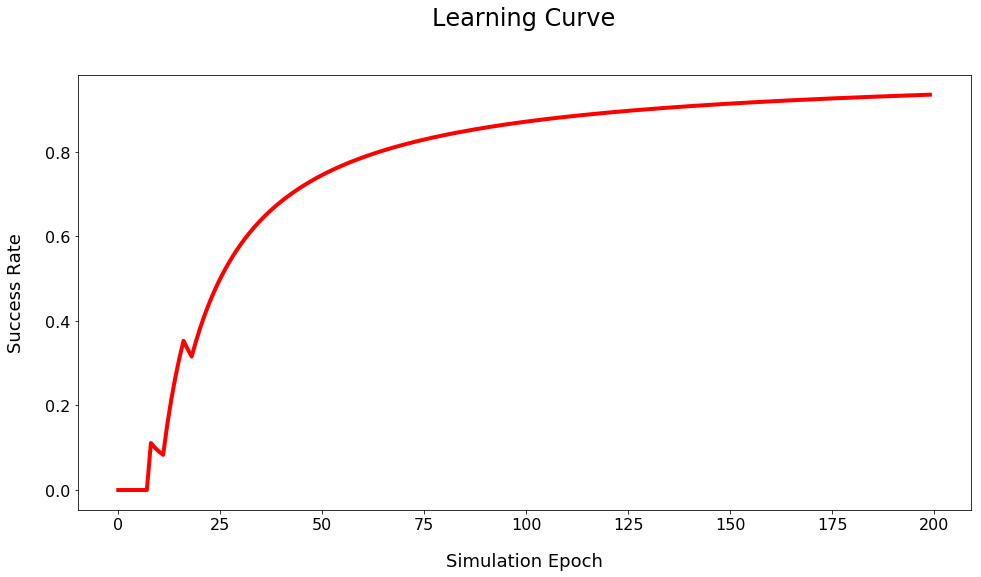

In [20]:
draw_learning_curve(curve)

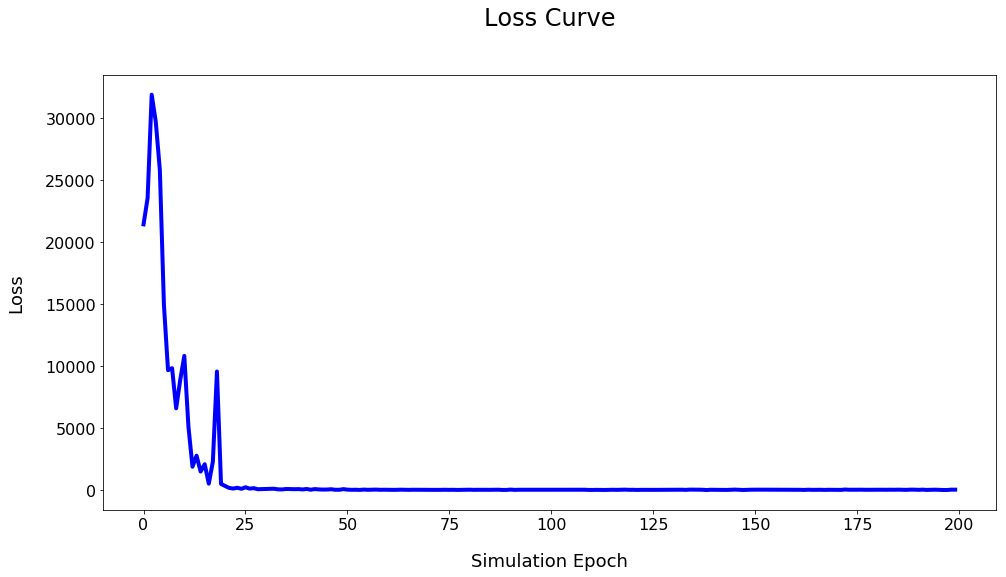

In [21]:
draw_loss_curve(losses)

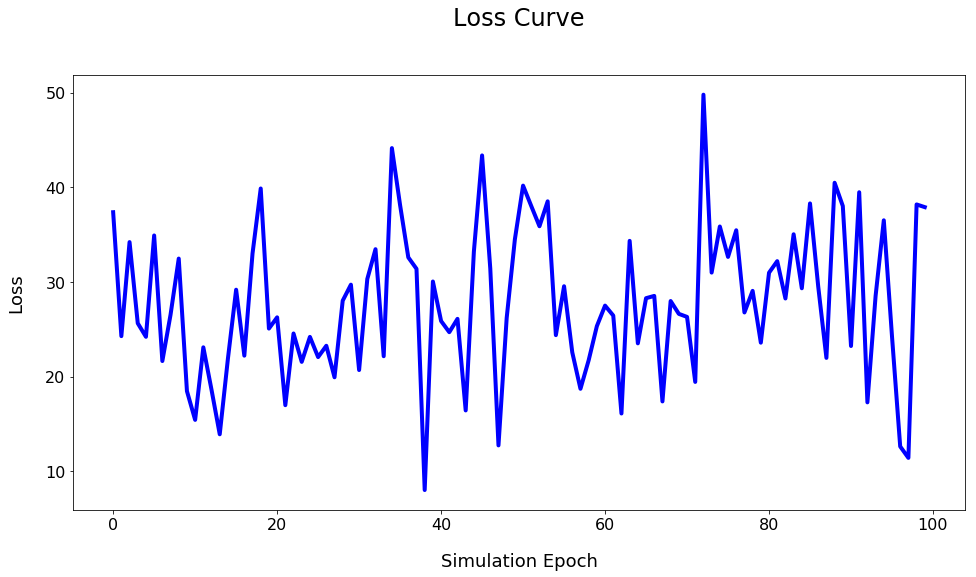

In [22]:
draw_loss_curve(losses[-100:])

In [23]:
saver = tf.train.Saver()

In [24]:
#saver.save(agent.model.sess, "trained_model/flight_200/model.ckpt")  

In [25]:
curve

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.1111111111111111,
 0.1,
 0.09090909090909091,
 0.08333333333333333,
 0.15384615384615385,
 0.21428571428571427,
 0.26666666666666666,
 0.3125,
 0.35294117647058826,
 0.3333333333333333,
 0.3157894736842105,
 0.35,
 0.38095238095238093,
 0.4090909090909091,
 0.43478260869565216,
 0.4583333333333333,
 0.48,
 0.5,
 0.5185185185185185,
 0.5357142857142857,
 0.5517241379310345,
 0.5666666666666667,
 0.5806451612903226,
 0.59375,
 0.6060606060606061,
 0.6176470588235294,
 0.6285714285714286,
 0.6388888888888888,
 0.6486486486486487,
 0.6578947368421053,
 0.6666666666666666,
 0.675,
 0.6829268292682927,
 0.6904761904761905,
 0.6976744186046512,
 0.7045454545454546,
 0.7111111111111111,
 0.717391304347826,
 0.723404255319149,
 0.7291666666666666,
 0.7346938775510204,
 0.74,
 0.7450980392156863,
 0.75,
 0.7547169811320755,
 0.7592592592592593,
 0.7636363636363637,
 0.7678571428571429,
 0.7719298245614035,
 0.7758620689655172,
 0.779661016949152